# Sanity Checks: The Manager's Smell Test

This notebook demonstrates **sanity checks** - a critical validation technique that applies business judgment to evaluate whether model recommendations make sense.

Understanding sanity checks is essential because:
- **Models can be wrong even when math is correct** - they may produce recommendations that are mathematically optimal but practically absurd
- **Sanity checks catch obvious problems** - they use business judgment to identify recommendations that don't make sense
- **They're quick but powerful** - a few minutes of sanity checking can prevent costly failures
- **They're the last line of defense** - catch problems that other validation techniques might miss


## Key Concepts

**Sanity Checks** apply business judgment to evaluate recommendations:
- You ask: "Does this make sense?"
- You use your knowledge of the business to evaluate recommendations
- You catch recommendations that are mathematically correct but practically wrong
- You identify obvious problems before implementation

**Why It Matters**:
- **Models can produce absurd recommendations** - even when the math is correct
- **Business judgment catches what math misses** - practical constraints, regulations, customer behavior
- **Sanity checks are quick but powerful** - they catch obvious problems immediately
- **They prevent costly failures** - catch problems before they cause damage

**Critical insight**: Sanity checks are not about being skeptical of models - they're about being thoughtful about recommendations. Every recommendation should pass the smell test.


## Scenario: Evaluating Model Recommendations

You receive several model recommendations for different business decisions. Your job is to evaluate whether each recommendation makes sense before implementing it.

**Examples to evaluate**:
1. **Staffing recommendation**: Model recommends zero staff for weekend shifts
2. **Pricing recommendation**: Model recommends pricing a product at $500 (normally $50)
3. **Inventory recommendation**: Model recommends negative inventory quantities
4. **Production recommendation**: Model recommends producing more than capacity allows

**The Question**: Which recommendations pass the sanity check? Which should be rejected?

**Decision**: Whether to implement each recommendation

**Sanity check criteria**: Does it make operational sense? Does it violate regulations? Will customers accept it?


## Step 1: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Step 2: Define Sanity Check Framework

Let's create a framework for evaluating recommendations:


In [2]:
def sanity_check(recommendation, check_type, context):
    """
    Perform a sanity check on a recommendation.
    Returns: (passes, reason)
    """
    checks = {
        'operational': {
            'zero_staff': recommendation == 0 and 'staff' in context,
            'negative_quantity': recommendation < 0,
            'exceeds_capacity': 'capacity' in context and recommendation > context.get('capacity', float('inf')),
            'impossible_schedule': 'schedule' in context and not context.get('feasible', True)
        },
        'regulatory': {
            'violates_minimum': 'minimum' in context and recommendation < context.get('minimum', 0),
            'violates_maximum': 'maximum' in context and recommendation > context.get('maximum', float('inf'))
        },
        'business': {
            'unrealistic_price': 'price' in context and (recommendation < 0 or recommendation > context.get('max_reasonable', float('inf'))),
            'customer_unacceptable': 'customer' in context and not context.get('acceptable', True)
        }
    }
    
    # Check each category
    for category, category_checks in checks.items():
        for check_name, check_result in category_checks.items():
            if check_result:
                return (False, f"FAILS {category.upper()} check: {check_name}")
    
    return (True, "PASSES all sanity checks")

# Example recommendations to test
recommendations = [
    {
        'name': 'Staffing: Zero Staff on Weekends',
        'value': 0,
        'type': 'staffing',
        'context': {'staff': True, 'minimum': 4, 'feasible': True}
    },
    {
        'name': 'Pricing: $500 for $50 Product',
        'value': 500,
        'type': 'pricing',
        'context': {'price': True, 'normal_price': 50, 'max_reasonable': 100, 'customer': True, 'acceptable': False}
    },
    {
        'name': 'Inventory: Negative Quantity',
        'value': -50,
        'type': 'inventory',
        'context': {'capacity': 1000}
    },
    {
        'name': 'Production: Exceeds Capacity',
        'value': 1200,
        'type': 'production',
        'context': {'capacity': 1000}
    },
    {
        'name': 'Staffing: Reasonable Level',
        'value': 8,
        'type': 'staffing',
        'context': {'staff': True, 'minimum': 4, 'maximum': 15, 'feasible': True}
    }
]

print("SANITY CHECK FRAMEWORK:")
print("=" * 80)
print("Checking recommendations against:")
print("  • Operational feasibility")
print("  • Regulatory compliance")
print("  • Business reasonableness")
print("\n")


SANITY CHECK FRAMEWORK:
Checking recommendations against:
  • Operational feasibility
  • Regulatory compliance
  • Business reasonableness




## Step 3: Evaluate Each Recommendation

Let's evaluate each recommendation using sanity checks:


In [3]:
# Evaluate each recommendation
results = []

for rec in recommendations:
    passes, reason = sanity_check(rec['value'], rec['type'], rec['context'])
    
    results.append({
        'Recommendation': rec['name'],
        'Value': rec['value'],
        'Passes': passes,
        'Reason': reason,
        'Action': 'ACCEPT' if passes else 'REJECT'
    })
    
    print(f"{rec['name']}:")
    print(f"  Value: {rec['value']}")
    print(f"  Sanity Check: {'✓ PASSES' if passes else '✗ FAILS'}")
    print(f"  Reason: {reason}")
    print(f"  Action: {'ACCEPT' if passes else 'REJECT'}")
    print()

results_df = pd.DataFrame(results)
print("=" * 80)


Staffing: Zero Staff on Weekends:
  Value: 0
  Sanity Check: ✗ FAILS
  Reason: FAILS OPERATIONAL check: zero_staff
  Action: REJECT

Pricing: $500 for $50 Product:
  Value: 500
  Sanity Check: ✗ FAILS
  Reason: FAILS BUSINESS check: unrealistic_price
  Action: REJECT

Inventory: Negative Quantity:
  Value: -50
  Sanity Check: ✗ FAILS
  Reason: FAILS OPERATIONAL check: negative_quantity
  Action: REJECT

Production: Exceeds Capacity:
  Value: 1200
  Sanity Check: ✗ FAILS
  Reason: FAILS OPERATIONAL check: exceeds_capacity
  Action: REJECT

Staffing: Reasonable Level:
  Value: 8
  Sanity Check: ✓ PASSES
  Reason: PASSES all sanity checks
  Action: ACCEPT



## Step 4: Create a Sanity Check Checklist

Let's create a reusable checklist for sanity checks:


In [4]:
# Create sanity check checklist
checklist = pd.DataFrame({
    'Check Category': [
        'Operational Feasibility',
        'Operational Feasibility',
        'Operational Feasibility',
        'Regulatory Compliance',
        'Regulatory Compliance',
        'Business Reasonableness',
        'Business Reasonableness',
        'Business Reasonableness'
    ],
    'Question': [
        'Is the recommendation possible?',
        'Does it violate capacity limits?',
        'Does it create impossible schedules?',
        'Does it meet minimum requirements?',
        'Does it exceed maximum limits?',
        'Is the price reasonable?',
        'Will customers/stakeholders accept it?',
        'Does it align with business strategy?'
    ],
    'Example Failures': [
        'Negative quantities, zero when minimum required',
        'Production exceeds capacity, inventory exceeds storage',
        'Schedules violate time constraints',
        'Staffing below legal minimum, safety violations',
        'Exceeds budget limits, violates contracts',
        'Prices 10x normal, negative prices',
        'Customers will reject, violates brand positioning',
        'Conflicts with strategic goals'
    ]
})

print("SANITY CHECK CHECKLIST:")
print("=" * 80)
display(checklist)

print("\nHOW TO USE:")
print("  1. Go through each question for every recommendation")
print("  2. If any check fails, investigate or reject the recommendation")
print("  3. Customize the checklist for your specific business context")
print("  4. Use it consistently to catch problems early")


SANITY CHECK CHECKLIST:


,Check Category,Question,Example Failures
0,Operational Feasibility,Is the recommendation possible?,"Negative quantities, zero when minimum required"
1,Operational Feasibility,Does it violate capacity limits?,"Production exceeds capacity, inventory exceeds..."
2,Operational Feasibility,Does it create impossible schedules?,Schedules violate time constraints
3,Regulatory Compliance,Does it meet minimum requirements?,"Staffing below legal minimum, safety violations"
4,Regulatory Compliance,Does it exceed maximum limits?,"Exceeds budget limits, violates contracts"
5,Business Reasonableness,Is the price reasonable?,"Prices 10x normal, negative prices"
6,Business Reasonableness,Will customers/stakeholders accept it?,"Customers will reject, violates brand positioning"
7,Business Reasonableness,Does it align with business strategy?,Conflicts with strategic goals



HOW TO USE:
  1. Go through each question for every recommendation
  2. If any check fails, investigate or reject the recommendation
  3. Customize the checklist for your specific business context
  4. Use it consistently to catch problems early


## Step 5: Visualize Sanity Check Results

Let's visualize which recommendations pass and fail:


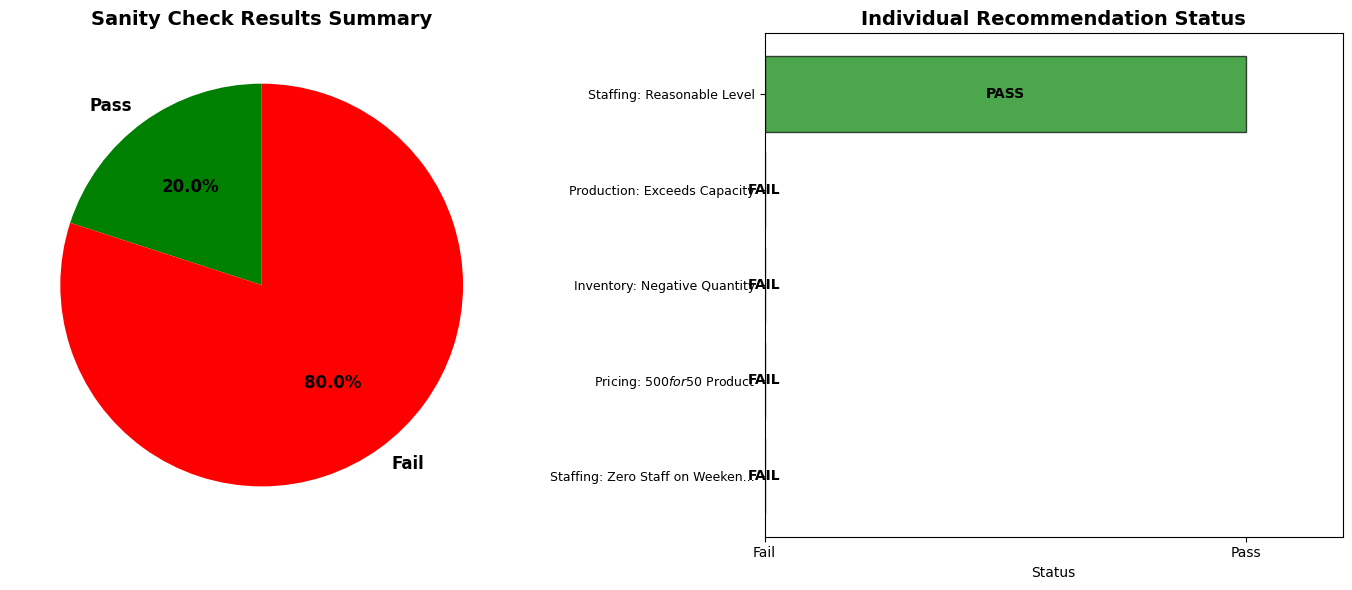


SUMMARY:
  Total Recommendations: 5
  Passed: 1
  Failed: 4
  Rejection Rate: 80.0%

  ⚠️  4 recommendations failed sanity checks and should be rejected or investigated


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Pass/Fail Summary
ax1 = axes[0]
pass_count = sum(results_df['Passes'])
fail_count = len(results_df) - pass_count
colors = ['green', 'red']
ax1.pie([pass_count, fail_count], labels=['Pass', 'Fail'], autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontweight': 'bold', 'fontsize': 12})
ax1.set_title('Sanity Check Results Summary', fontweight='bold', fontsize=14)

# Plot 2: Individual Recommendations
ax2 = axes[1]
y_pos = np.arange(len(results_df))
colors_bar = ['green' if p else 'red' for p in results_df['Passes']]
bars = ax2.barh(y_pos, [1 if p else 0 for p in results_df['Passes']], color=colors_bar, alpha=0.7, edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in results_df['Recommendation']], fontsize=9)
ax2.set_xlabel('Status')
ax2.set_title('Individual Recommendation Status', fontweight='bold', fontsize=14)
ax2.set_xlim(0, 1.2)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Fail', 'Pass'])

# Add labels
for i, (bar, passes) in enumerate(zip(bars, results_df['Passes'])):
    label = 'PASS' if passes else 'FAIL'
    ax2.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
             label, ha='center', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\nSUMMARY:")
print(f"  Total Recommendations: {len(results_df)}")
print(f"  Passed: {pass_count}")
print(f"  Failed: {fail_count}")
print(f"  Rejection Rate: {fail_count/len(results_df)*100:.1f}%")
print(f"\n  ⚠️  {fail_count} recommendations failed sanity checks and should be rejected or investigated")


## Step 6: Practice Creating Your Own Checklist

Think about your business context and create a customized sanity check checklist:


In [6]:
# Template for custom checklist
custom_checklist_template = """
YOUR CUSTOM SANITY CHECK CHECKLIST:

1. OPERATIONAL FEASIBILITY
   [ ] Is this recommendation physically possible?
   [ ] Does it violate capacity constraints?
   [ ] Can we actually implement this?
   [ ] Add your specific operational checks here: _______________

2. REGULATORY COMPLIANCE
   [ ] Does it meet minimum requirements?
   [ ] Does it exceed maximum limits?
   [ ] Does it comply with regulations?
   [ ] Add your specific regulatory checks here: _______________

3. BUSINESS REASONABLENESS
   [ ] Will customers/stakeholders accept this?
   [ ] Does it align with business strategy?
   [ ] Is the cost/benefit reasonable?
   [ ] Add your specific business checks here: _______________

4. DATA QUALITY
   [ ] Are the inputs reasonable?
   [ ] Could there be data errors?
   [ ] Are assumptions realistic?
   [ ] Add your specific data quality checks here: _______________

CUSTOMIZE THIS CHECKLIST FOR YOUR SPECIFIC CONTEXT!
"""

print(custom_checklist_template)
print("\nPRACTICE:")
print("  • Think about a decision context in your work")
print("  • Create a sanity check checklist specific to that context")
print("  • Use it to evaluate model recommendations")
print("  • Refine it based on what you learn")



YOUR CUSTOM SANITY CHECK CHECKLIST:

1. OPERATIONAL FEASIBILITY
   [ ] Is this recommendation physically possible?
   [ ] Does it violate capacity constraints?
   [ ] Can we actually implement this?
   [ ] Add your specific operational checks here: _______________

2. REGULATORY COMPLIANCE
   [ ] Does it meet minimum requirements?
   [ ] Does it exceed maximum limits?
   [ ] Does it comply with regulations?
   [ ] Add your specific regulatory checks here: _______________

3. BUSINESS REASONABLENESS
   [ ] Will customers/stakeholders accept this?
   [ ] Does it align with business strategy?
   [ ] Is the cost/benefit reasonable?
   [ ] Add your specific business checks here: _______________

4. DATA QUALITY
   [ ] Are the inputs reasonable?
   [ ] Could there be data errors?
   [ ] Are assumptions realistic?
   [ ] Add your specific data quality checks here: _______________

CUSTOMIZE THIS CHECKLIST FOR YOUR SPECIFIC CONTEXT!


PRACTICE:
  • Think about a decision context in your work


## Summary: Sanity Checks

**What We Learned**:
- **Sanity checks** apply business judgment to evaluate whether recommendations make sense
- **Models can be wrong even when math is correct** - they may produce recommendations that are mathematically optimal but practically absurd
- **Sanity checks catch obvious problems** - they use business knowledge to identify recommendations that don't make sense
- **They're quick but powerful** - a few minutes of sanity checking can prevent costly failures

**Key Insights**:
1. **Always perform sanity checks**: Every recommendation should pass the smell test
2. **Use business judgment**: Your knowledge of the business is as important as the model's math
3. **Create a checklist**: A systematic checklist ensures you don't miss important checks
4. **Customize for your context**: Different businesses need different sanity check criteria

**Practical Application**:
- Always perform sanity checks before implementing recommendations
- Create a customized checklist for your business context
- Use business judgment to catch problems that math misses
- Don't blindly trust model outputs - apply your judgment
- Sanity checks are the last line of defense against bad recommendations
